In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

train_path = '/kaggle/input/faceer2/train'
test_path = '/kaggle/input/faceer2/test'

def load_images_labels(dataset_path):
    images = []
    labels = []

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                # Load the image using OpenCV and convert it to grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image to a common size (e.g., 28x28 pixels)
                image = cv2.resize(image, (100, 100))

                # Normalize pixel values to the range [0, 1]
                image = image / 255.0

                # Append the image data to the list
                images.append(image)

                # Append the corresponding label to the labels list
                labels.append(class_name)

    # Convert the lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load train and test data
train_images, train_labels = load_images_labels(train_path)
test_images, test_labels = load_images_labels(test_path)

# Shuffle the train and test data (optional)
train_indices = np.random.permutation(len(train_images))
test_indices = np.random.permutation(len(test_images))

train_images = train_images[train_indices]
train_labels = train_labels[train_indices]

test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

# Encoding labels
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_labels)
test_label_encoded = label_encoder.transform(test_labels)

onehot_encoder = OneHotEncoder(sparse_output=False)
train_label_encoded = train_label_encoded.reshape(-1, 1)
test_label_encoded = test_label_encoded.reshape(-1, 1)

train_onehot_encoded = onehot_encoder.fit_transform(train_label_encoded)
test_onehot_encoded = onehot_encoder.transform(test_label_encoded)

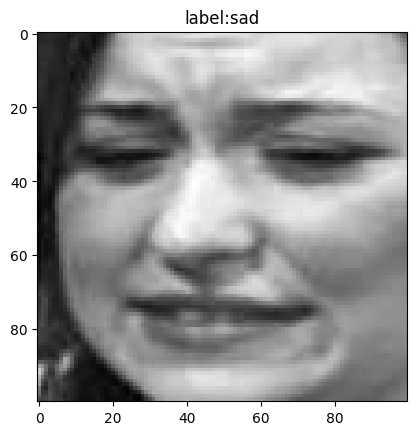

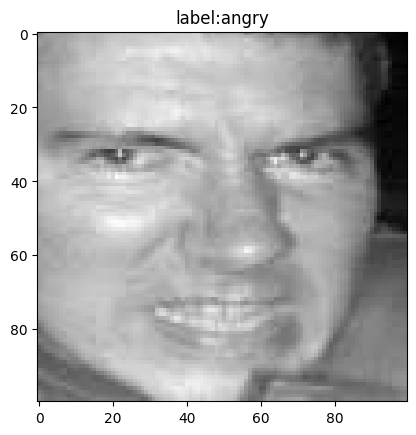

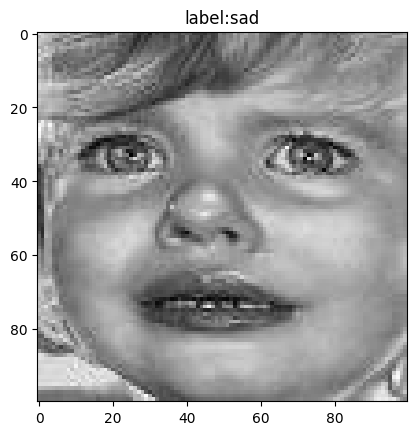

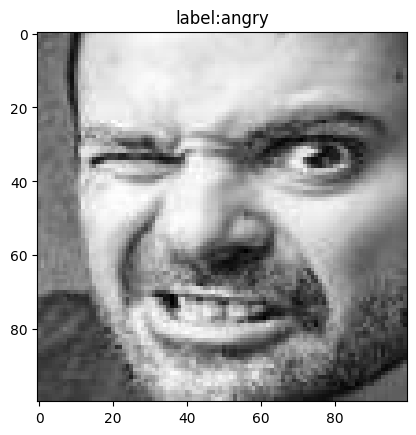

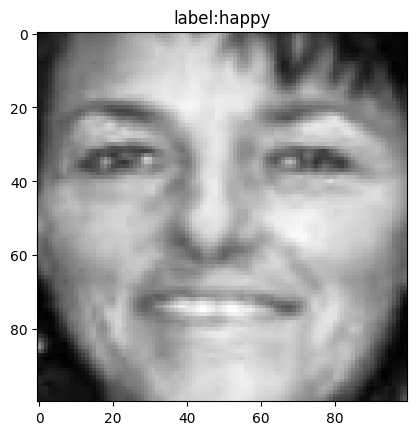

In [3]:
#Visualizing the train images with labels
import matplotlib.pyplot as plt

r1 = np.random.choice(len(train_images), 5, replace=False)

for i in r1:
    plt.imshow(train_images[i],cmap='gray')
    plt.title(f'label:{train_labels[i]}')
    plt.show()

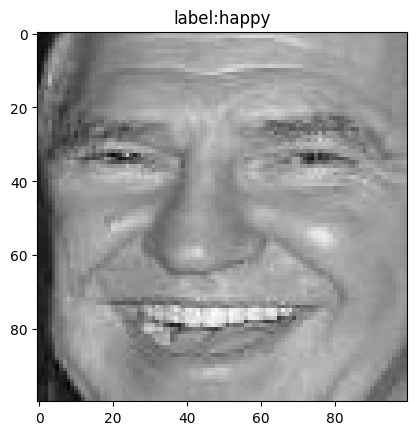

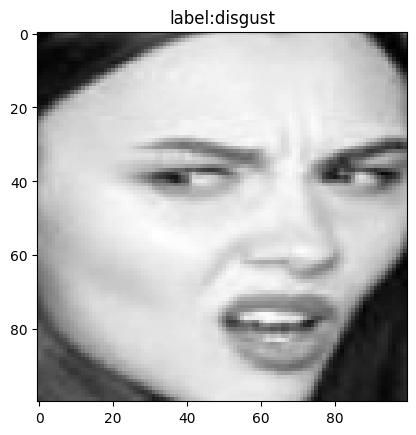

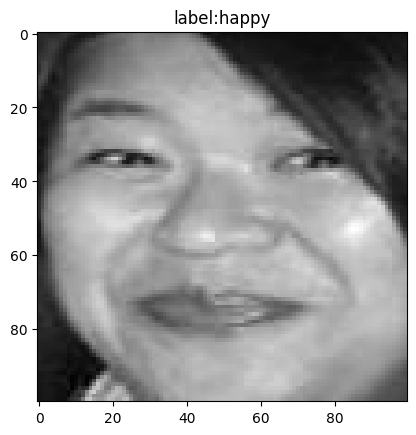

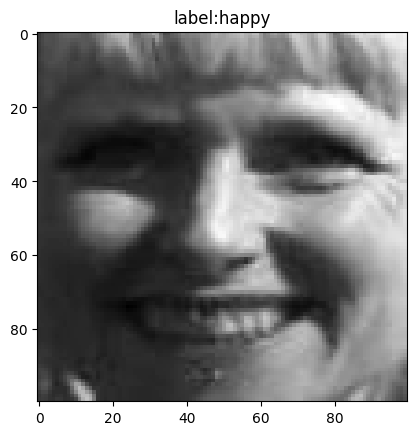

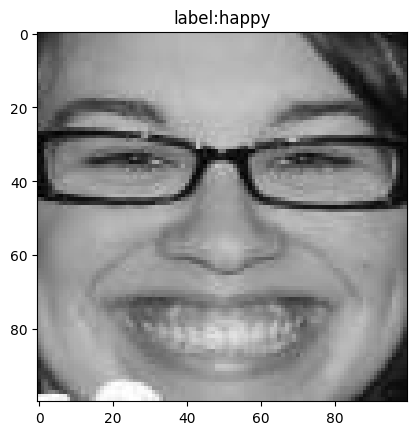

In [4]:
#Visualizing the test images with labels

r2 = np.random.choice(len(test_images), 5, replace=False)

for i in r2:
    plt.imshow(test_images[i],cmap='gray')
    plt.title(f'label:{test_labels[i]}')
    plt.show()

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
from sklearn.model_selection import train_test_split

(x_train, x_val, y_train, y_val) = train_test_split(train_images, train_onehot_encoded, test_size=0.08, random_state=0)
print("Train data shape:", x_train.shape)
print("Test data shape:", x_val.shape)
print("Train data shape:", y_train.shape)
print("test data shape:", y_val.shape)

Train data shape: (7735, 100, 100)
Test data shape: (673, 100, 100)
Train data shape: (7735, 7)
test data shape: (673, 7)


In [7]:
x_train = np.expand_dims(x_train, axis =-1) #adds a channel dimension to grayscale images in x_train to make them compatible with Tensorflow library
train_datagen = datagen.flow(x_train, y_train, batch_size=32) #for augmenting training data in batches of 64 samples at a time during model training.

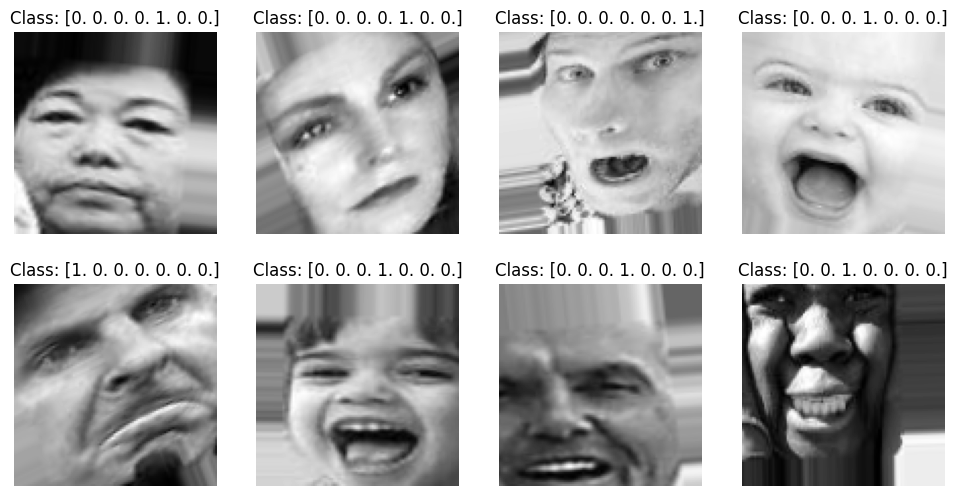

In [8]:
# Generate a batch of augmented images
batch_x, batch_y = train_datagen.next()

# Plot a few examples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch_x[i].reshape(100, 100), cmap='gray')  # Assuming images are grayscale
    ax.set_title(f'Class: {batch_y[i]}')
    ax.axis('off')
plt.show()

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation

In [10]:
# Assuming you have onehot_encoded as your one-hot encoded labels
class_labels = np.argmax(y_train, axis=1)
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = dict(enumerate(class_weights))

In [11]:
"""model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(100,100, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Adjusted dropout rate

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Adjusted dropout rate

model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Adjusted dropout rate

model.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
#model.add(Conv2D(512, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Adjusted dropout rate


model.add(Flatten())


model.add(Dense(1024, kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()"""

"model = Sequential()\n\nmodel.add(Conv2D(64, (3, 3), input_shape=(100,100, 1), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.3))  # Adjusted dropout rate\n\nmodel.add(Conv2D(128, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(128, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.3))  # Adjusted dropout rate\n\nmodel.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(256, (3, 3), activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(Dropout(0.3))  # Adjusted dropout rate\n\nmodel.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.05)))\nmodel.add(BatchNormalization())\n#model.add(Conv2D(512, (3, 3), activation='relu'))

In [20]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(100,100,1) ,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 batch_normalization_10 (Ba  (None, 98, 98, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_11 (Ba  (None, 96, 96, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                      

In [21]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_datagen, epochs=100, batch_size=128, validation_data = (x_val, y_val),
                    class_weight=class_weight_dict, callbacks=[reduce_lr])

Epoch 1/100


2024-03-31 16:57:41.229256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


242/242 [==============================] - 31s 95ms/step - loss: 1.9894 - accuracy: 0.1997 - val_loss: 1.8393 - val_accuracy: 0.3551 - lr: 0.0010
Epoch 2/100
242/242 [==============================] - 23s 94ms/step - loss: 1.8941 - accuracy: 0.2412 - val_loss: 2.0178 - val_accuracy: 0.2734 - lr: 0.0010
Epoch 3/100
242/242 [==============================] - 23s 94ms/step - loss: 1.8624 - accuracy: 0.2630 - val_loss: 2.0531 - val_accuracy: 0.3343 - lr: 0.0010
Epoch 4/100
242/242 [==============================] - 23s 93ms/step - loss: 1.8059 - accuracy: 0.3034 - val_loss: 1.9234 - val_accuracy: 0.3314 - lr: 0.0010
Epoch 5/100
242/242 [==============================] - 23s 94ms/step - loss: 1.7320 - accuracy: 0.3471 - val_loss: 1.6942 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 6/100
242/242 [==============================] - 23s 94ms/step - loss: 1.6614 - accuracy: 0.3835 - val_loss: 1.7661 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 7/100
242/242 [==============================] - 23s 94ms/

In [22]:
print('Final training loss ', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss  0.5018284916877747
Final training accuracy  0.8265029191970825


In [23]:
testLoss, testAccuracy = model.evaluate(test_images, test_onehot_encoded)

63/63 [==============================] - 1s 21ms/step - loss: 0.4871 - accuracy: 0.8362


In [24]:
print('Testing loss ', testLoss)
print('Testing accuracy ', testAccuracy)

Testing loss  0.487076073884964
Testing accuracy  0.8362283110618591


In [25]:
y_pred = model.predict(test_images)

y_pred_class = np.argmax(y_pred, axis = 1)

y_true = np.argmax(test_onehot_encoded, axis = 1)

63/63 [==============================] - 1s 19ms/step


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       148
           1       0.82      0.73      0.77       158
           2       0.61      0.74      0.67        92
           3       0.96      0.89      0.93       694
           4       0.81      0.80      0.80       408
           5       0.75      0.82      0.78       314
           6       0.79      0.84      0.81       201

    accuracy                           0.84      2015
   macro avg       0.79      0.81      0.80      2015
weighted avg       0.84      0.84      0.84      2015



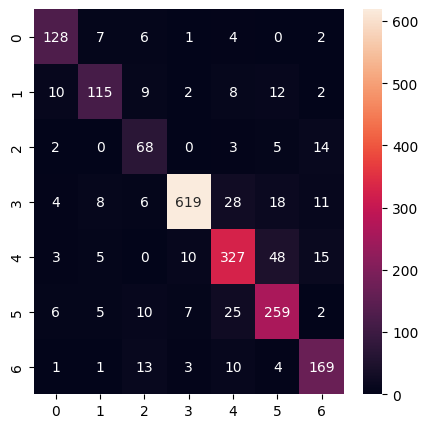

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d");

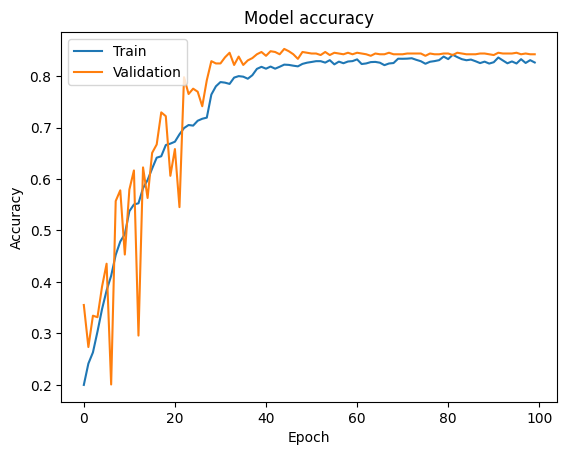

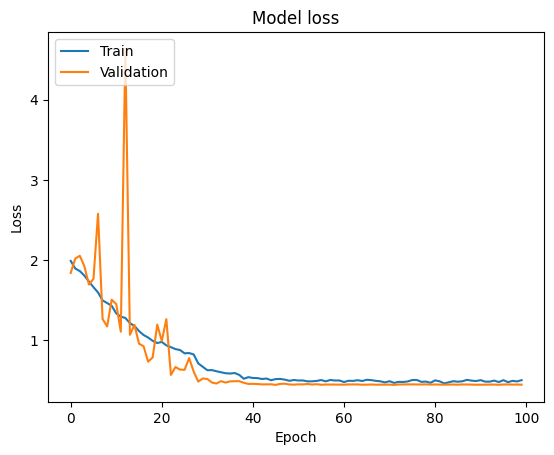

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming 'history' contains the training history returned by model.fit()
plot_training_history(history)


In [18]:
model.save('FER_Kaggle_Updated838281.h5')